In [1]:
options(warn = -1)
options(scipen = 100)
library(nnet)
library(party)
library(randomForest)
library(e1071)
library(caret)
library(dplyr)
library(Metrics)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin


Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, 

In [2]:
# 정확도 (결정계수)
rsquare <- function(pred, y) {
    return (1- (sum((y-pred)^2) / sum((y-mean(y))^2)))
}

# 인공 신경망
f.nnet <- function(data.tr, x, y) {
    model.nnet <- nnet(cluster ~ ., data=data.tr, size = 10) 
    pred <- predict(model.nnet, x, type="class")
    return (mean(pred == y))
}

# 의사 결정 나무
f.ctree <- function(data.tr, x, y) {
    model.ctree <- ctree(cluster ~ ., data=data.tr)
    pred <- predict(model.ctree, x)
    return (mean(pred == y))
}

# RandomForest
f.randomForest <- function(data.tr, x, y) {
    model.rf <- randomForest(cluster ~ ., data=data.tr, ntree=100)
    pred <- predict(model.rf, x)
    return (mean(pred == y))
}


# SVM
f.svm <- function(data.tr, x, y) {
    model.svm <- svm(cluster ~., data=data.tr)
    pred <- predict(model.svm, x)
    return (mean(pred == y))
}

# 다항 로지스틱 회귀분석
f.multinom <- function(data.tr, x, y) {
    model.multinom <- multinom(cluster ~ ., data=data.tr)
    pred <- predict(model.multinom, x)
    return (mean(pred == y))
}


In [3]:
rice <- read.csv("./plzFinal_ML.csv", fileEncoding = "utf-8")

In [4]:
temp <- read.csv("./fortest2.csv", fileEncoding = "utf-8")

In [5]:
data <- read.csv("./fortest1.csv", fileEncoding = "utf-8")

In [6]:
data

cluster,누적관객수,스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,배우점수2,배우점수3,배우점수4,배우점수5
1,4039891,23.79760,2,10,3,3.000000,4.000000,4.000000,2.000000,0.000000,0.000000
1,3678156,48.26242,2,10,8,2.000000,8.250000,8.250000,4.062019,8.250000,4.062019
1,3117859,36.90476,1,10,0,2.333333,4.000000,4.000000,2.000000,0.000000,0.000000
1,4313101,35.27944,3,10,3,3.571429,6.777778,6.777778,4.509250,6.777778,4.509250
1,3024666,21.64329,3,10,0,3.500000,7.666667,7.666667,5.153456,7.666667,5.153456
1,4111237,28.49592,2,20,6,3.500000,6.500000,6.500000,3.031895,3.250000,2.549510
1,3134421,18.14320,1,10,1,3.571429,6.777778,6.777778,4.509250,6.777778,4.509250
1,3755233,40.17705,3,10,5,1.500000,11.750000,11.750000,4.959511,11.750000,4.959511
1,3587182,34.01942,1,10,7,4.000000,4.000000,4.000000,2.000000,0.000000,0.000000
1,3420172,32.55022,3,10,4,4.000000,11.375000,11.375000,5.672156,11.375000,5.672156


In [7]:
data <- cbind(data,조연점수=temp$조연점수 )

In [8]:
data <- subset(data, select = -c(누적관객수, 배우점수2, 배우점수3, 배우점수4, 배우점수5))

In [9]:
data

cluster,스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,조연점수
1,23.79760,2,10,3,3.000000,4.000000,8.000000
1,48.26242,2,10,8,2.000000,8.250000,12.250000
1,36.90476,1,10,0,2.333333,4.000000,10.600000
1,35.27944,3,10,3,3.571429,6.777778,10.600000
1,21.64329,3,10,0,3.500000,7.666667,14.500000
1,28.49592,2,20,6,3.500000,6.500000,11.500000
1,18.14320,1,10,1,3.571429,6.777778,7.900000
1,40.17705,3,10,5,1.500000,11.750000,10.250000
1,34.01942,1,10,7,4.000000,4.000000,8.000000
1,32.55022,3,10,4,4.000000,11.375000,7.000000


In [10]:
data$cluster <- as.factor(data$cluster)

In [11]:
data

cluster,스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,조연점수
1,23.79760,2,10,3,3.000000,4.000000,8.000000
1,48.26242,2,10,8,2.000000,8.250000,12.250000
1,36.90476,1,10,0,2.333333,4.000000,10.600000
1,35.27944,3,10,3,3.571429,6.777778,10.600000
1,21.64329,3,10,0,3.500000,7.666667,14.500000
1,28.49592,2,20,6,3.500000,6.500000,11.500000
1,18.14320,1,10,1,3.571429,6.777778,7.900000
1,40.17705,3,10,5,1.500000,11.750000,10.250000
1,34.01942,1,10,7,4.000000,4.000000,8.000000
1,32.55022,3,10,4,4.000000,11.375000,7.000000


In [12]:
cor(as.numeric(data$cluster), data$조연점수)

[1] 0.6813763

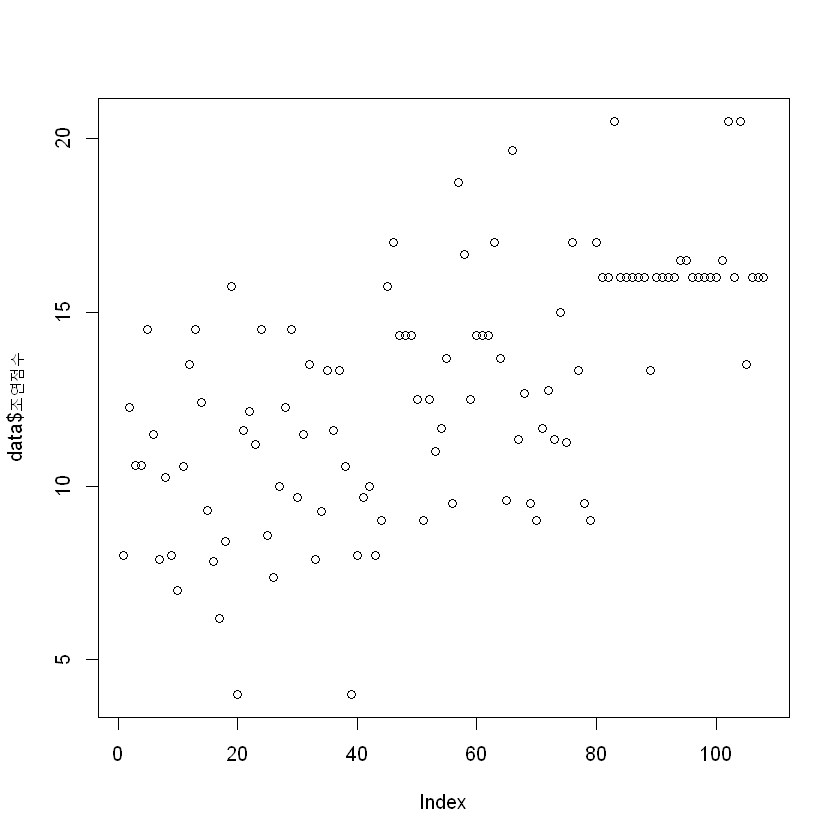

In [13]:
plot(data$조연점수)

In [14]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 101
samp <- createDataPartition(data$cluster, p = 0.7, list = F)
for (i in 1:n) {


    # 학습용 데이터 셋
    data.tr <- subset(data[samp,], select = c(cluster, 배우점수, 조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, 배급사점수))

    # 검증용 데이터셋
    data.test <- subset(data[-samp,], select = c(cluster, 배우점수,  조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, 배급사점수))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  103
initial  value 82.713720 
iter  10 value 77.331213
iter  20 value 59.655941
iter  30 value 48.360321
iter  40 value 40.592607
iter  50 value 38.223044
iter  60 value 37.880350
iter  70 value 35.287047
iter  80 value 31.747318
iter  90 value 30.498305
iter 100 value 29.913686
final  value 29.913686 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 85.492203 
iter  10 value 75.541465
iter  20 value 60.279475
iter  30 value 44.113399
iter  40 value 37.760638
iter  50 value 32.222582
iter  60 value 28.665681
iter  70 value 28.327133
iter  80 value 28.304954
iter  90 value 28.299576
iter 100 value 28.289194
final  value 28.289194 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 4

initial  value 128.173807 
iter  10 value 80.300172
iter  20 value 72.135173
iter  30 value 52.890270
iter  40 value 46.226149
iter  50 value 39.851434
iter  60 value 29.107103
iter  70 value 25.925987
iter  80 value 25.322132
iter  90 value 25.138814
iter 100 value 25.075160
final  value 25.075160 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 104.754353 
iter  10 value 82.108575
iter  20 value 76.773235
iter  30 value 73.924926
iter  40 value 73.155037
iter  50 value 67.749245
iter  60 value 53.542900
iter  70 value 49.558476
iter  80 value 41.802917
iter  90 value 41.139523
iter 100 value 41.002011
final  value 41.002011 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter 

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 94.533563 
iter  10 value 79.368382
iter  20 value 56.662303
iter  30 value 41.974904
iter  40 value 31.382680
iter  50 value 26.386841
iter  60 value 24.618052
iter  70 value 24.512009
iter  80 value 24.496754
iter  90 value 24.456439
iter 100 value 24.452543
final  value 24.452543 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 105.245812 
iter  10 value 82.845709
iter  20 value 72.125624
iter  30 value 62.096362
iter  40 value 59.230367
iter  50 value 57.795257
iter  60 value 57.012742
iter  70 value 56.806986
iter  80 value 55.614161
iter  90 value 55.411398
iter 100 value 55.399059
final  value 

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 110.305190 
iter  10 value 78.059422
iter  20 value 67.078141
iter  30 value 62.794143
iter  40 value 61.699482
iter  50 value 61.131411
iter  60 value 61.059630
iter  70 value 61.058331
final  value 61.058213 
converged
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 123.467107 
iter  10 value 83.293418
iter  20 value 78.609169
iter  30 value 65.308623
iter  40 value 50.178699
iter  50 value 40.776454
iter  60 value 36.306045
iter  70 value 34.168210
iter  80 value 28.110394
iter  90 value 23.870403
iter 100 value 21.594069
final  value 21.594069 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 110.056899 
iter  10 value 77.971056
iter  20 value 70.230775
iter  30 value 69.503566
iter  40 value 64.024372
iter  50 value 55.138717
iter  60 value 47.937805
iter  70 value 41.533309
iter  80 value 41.020195
iter  90 value 40.985298
iter 100 value 40.974696
final  value 40.974696 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 98.435362 
iter  10 value 82.995515
iter  20 value 79.779835
iter  30 value 71.676472
iter  40 value 69.741838
iter  50 value 67.769253
iter  60 value 59.670675
iter  70 value 43.942720
iter  80 value 41.832832
iter  90 value 41.291131
iter 100 value 40.954696
final  value 

initial  value 92.083791 
iter  10 value 79.420106
iter  20 value 65.621721
iter  30 value 50.412819
iter  40 value 36.825994
iter  50 value 28.876333
iter  60 value 27.769241
iter  70 value 27.054000
iter  80 value 26.957903
iter  90 value 26.957087
iter 100 value 26.939152
final  value 26.939152 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 98.742600 
iter  10 value 82.415596
iter  20 value 73.638888
iter  30 value 57.712025
iter  40 value 43.087397
iter  50 value 35.547818
iter  60 value 32.033903
iter  70 value 30.678320
iter  80 value 30.356333
iter  90 value 30.120551
iter 100 value 29.992511
final  value 29.992511 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  3

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 162.140986 
iter  10 value 79.023796
iter  20 value 74.547704
iter  30 value 70.681769
iter  40 value 67.176922
iter  50 value 58.955651
iter  60 value 56.563660
iter  70 value 56.055339
iter  80 value 55.864207
iter  90 value 55.750844
iter 100 value 55.726407
final  value 55.726407 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 89.290911 
iter  10 value 81.397843
iter  20 value 73.519262
iter  30 value 65.690443
iter  40 value 61.408215
iter  50 value 60.304307
iter  60 value 60.149439
iter  70 value 60.126858
iter  80 value 60.120356
iter  90 value 60.119193
iter 100 value 59.996085
final  value 

initial  value 143.757488 
iter  10 value 80.415332
iter  20 value 79.526061
iter  30 value 79.118071
iter  40 value 69.467621
iter  50 value 56.298474
iter  60 value 46.262134
iter  70 value 45.512626
iter  80 value 44.885524
iter  90 value 44.480452
iter 100 value 43.560048
final  value 43.560048 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 87.992309 
iter  10 value 77.511012
iter  20 value 58.346858
iter  30 value 43.431544
iter  40 value 34.121506
iter  50 value 30.720075
iter  60 value 21.213453
iter  70 value 20.003666
iter  80 value 19.981005
iter  90 value 19.978020
iter 100 value 19.972458
final  value 19.972458 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 125.959251 
iter  10 value 80.734628
iter  20 value 75.408614
iter  30 value 68.541066
iter  40 value 60.275721
iter  50 value 57.850436
iter  60 value 57.822400
iter  70 value 57.716963
iter  80 value 56.846635
iter  90 value 48.679344
iter 100 value 43.874306
final  value 43.874306 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 114.561101 
iter  10 value 75.762153
iter  20 value 64.765332
iter  30 value 53.729634
iter  40 value 48.711430
iter  50 value 44.424349
iter  60 value 40.922906
iter  70 value 39.516206
iter  80 value 38.267311
iter  90 value 38.125541
iter 100 value 38.094430
final  value

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 95.156496 
iter  10 value 82.925152
iter  20 value 76.737174
iter  30 value 62.278209
iter  40 value 58.888997
iter  50 value 57.722181
iter  60 value 57.233223
iter  70 value 53.688916
iter  80 value 52.137030
iter  90 value 51.800146
iter 100 value 51.716836
final  value 51.716836 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 88.476765 
iter  10 value 76.345975
iter  20 value 55.808143
iter  30 value 45.420594
iter  40 value 40.326076
iter  50 value 38.996873
iter  60 value 38.350735
iter  70 value 38.292493
iter  80 value 38.212211
iter  90 value 38.186309
iter 100 value 38.163136
final  value 3

initial  value 98.563913 
iter  10 value 78.004814
iter  20 value 63.998263
iter  30 value 53.334831
iter  40 value 48.360782
iter  50 value 48.113898
iter  60 value 48.106847
iter  70 value 46.179829
iter  80 value 39.558630
iter  90 value 37.967973
iter 100 value 37.099243
final  value 37.099243 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 88.022705 
iter  10 value 78.115695
iter  20 value 74.764008
iter  30 value 55.688367
iter  40 value 51.852972
iter  50 value 50.021183
iter  60 value 46.111791
iter  70 value 43.571909
iter  80 value 42.046938
iter  90 value 40.193387
iter 100 value 38.999813
final  value 38.999813 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  3

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 89.906209 
iter  10 value 83.105182
iter  20 value 79.502159
iter  30 value 75.070173
iter  40 value 73.222355
iter  50 value 67.716196
iter  60 value 64.068021
iter  70 value 62.345162
iter  80 value 62.107835
iter  90 value 61.771584
iter 100 value 60.193914
final  value 60.193914 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 99.230585 
iter  10 value 80.527417
iter  20 value 65.788934
iter  30 value 60.643632
iter  40 value 58.243840
iter  50 value 58.026577
iter  60 value 54.055847
iter  70 value 37.452356
iter  80 value 33.864168
iter  90 value 33.527700
iter 100 value 33.225736
final  value 3

initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 102.438955 
iter  10 value 79.625997
iter  20 value 63.656678
iter  30 value 51.552646
iter  40 value 47.829542
iter  50 value 31.541411
iter  60 value 28.452992
iter  70 value 28.152308
iter  80 value 27.798570
iter  90 value 27.733756
iter 100 value 27.615348
final  value 27.615348 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 68.984175
iter  20 value 43.672128
iter  30 value 43.414751
iter  30 value 43.414751
final  value 43.414751 
converged
# weights:  103
initial  value 114.372244 
iter  10 value 81.990742
iter  20 value 67.969059
iter  30 value 64.859241
iter  40 value 63.715173
iter  50 value 62.035132
iter  60 value 56.683340
iter  70 value 47.539138
iter  80 value 36.791668
iter  90 value 36.540717
iter 100 value 35.491255
final  value

In [15]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.7801209,0.6623377,1.000000,0.8051948,0.7922078
테스트,0.5445545,0.7741935,0.720856,0.7419355,0.7096774


In [16]:
mdata <- read.csv("./mainData.csv", fileEncoding = "utf-8")

In [17]:
mdata

영화명,누적매출액,누적관객수,스크린수,상영횟수,개봉일,배급사,등급,장르,감독,...,스크린점유율,배우누적점수,배우점수,감독점수,장르_관객점수부여,휴일,X12세이상관람가,X15세이상관람가,전체관람가,청소년관람불가
7급 공무원,26380710000,4039891,475,90779,2009-04-22,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,"코미디,액션,드라마,범죄",신태라,...,23.79760,6.50000,4.000000,3.000000,10,9,TRUE,FALSE,FALSE,FALSE
82년생 김지영,30298542310,3678156,1486,145441,2019-10-23,롯데컬처웍스(주)롯데엔터테인먼트,12세이상관람가,드라마,김도영,...,48.26242,14.75000,8.250000,2.000000,10,8,TRUE,FALSE,FALSE,FALSE
감기,21774884000,3117859,806,55046,2013-08-14,아이러브시네마,15세이상관람가,"드라마,어드벤처,액션",김성수,...,36.90476,10.50000,4.000000,2.333333,10,8,FALSE,TRUE,FALSE,FALSE
강철중: 공공의 적 1-1,28638460100,4313101,707,74157,2008-06-19,"CJ ENM,(주)시네마서비스",15세이상관람가,"드라마,액션",강우석,...,35.27944,10.63492,6.777778,3.571429,10,9,FALSE,TRUE,FALSE,FALSE
거북이 달린다,20618276000,3024666,432,69946,2009-06-11,(주)쇼박스,15세이상관람가,"드라마,액션,범죄",이연우,...,21.64329,17.66667,7.666667,3.500000,10,9,FALSE,TRUE,FALSE,FALSE
건축학개론,30223590400,4111237,593,106069,2012-03-22,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,"멜로/로맨스,드라마",이용주,...,28.49592,16.75000,6.500000,3.500000,20,10,TRUE,FALSE,FALSE,FALSE
공공의 적 2,20091127000,3134421,299,40642,2005-01-27,(주)시네마서비스,15세관람가,드라마,강우석,...,18.14320,13.27778,6.777778,3.571429,10,12,FALSE,TRUE,FALSE,FALSE
국가부도의 날,30893315837,3755233,1180,101077,2018-11-28,CJ ENM,12세이상관람가,드라마,최국희,...,40.17705,36.41667,11.750000,1.500000,10,9,TRUE,FALSE,FALSE,FALSE
귀향,27249801990,3587182,876,90288,2016-02-24,(주)와우픽쳐스,15세이상관람가,드라마,조정래,...,34.01942,44.00000,4.000000,4.000000,10,9,FALSE,TRUE,FALSE,FALSE
그것만이 내 세상,27456797382,3420172,956,95437,2018-01-17,CJ ENM,12세이상관람가,"코미디,드라마",최성현,...,32.55022,15.62500,11.375000,4.000000,10,9,TRUE,FALSE,FALSE,FALSE


In [18]:
colnames(mdata)

[1] "영화명"               "누적매출액"           "누적관객수"          
 [4] "스크린수"             "상영횟수"             "개봉일"              
 [7] "배급사"               "등급"                 "장르"                
[10] "감독"                 "주연"                 "제작사"              
[13] "조연"                 "cluster"              "감독_배우시너지"     
[16] "감독_배우악연"        "상영횟수당누적관객수" "스크린점유율"        
[19] "배우누적점수"         "배우점수"             "감독점수"            
[22] "장르_관객점수부여"    "휴일"                 "X12세이상관람가"     
[25] "X15세이상관람가"      "전체관람가"           "청소년관람불가"

In [19]:
mdata$배급사 <- as.character(mdata$배급사)

In [20]:
(strsplit(as.character(mdata$배급사),",")[[4]][1])

[1] "CJ ENM"

In [21]:
for (i in 1:nrow(mdata)) {
    mdata$배급사[i] <- ((strsplit(as.character(mdata$배급사),","))[[i]][1])
    }

In [22]:
mdata$배급사

[1] "롯데쇼핑㈜롯데엔터테인먼트"       "롯데컬처웍스(주)롯데엔터테인먼트"
  [3] "아이러브시네마"                   "CJ ENM"                          
  [5] "(주)쇼박스"                       "롯데쇼핑㈜롯데엔터테인먼트"      
  [7] "(주)시네마서비스"                 "CJ ENM"                          
  [9] "(주)와우픽쳐스"                   "CJ ENM"                          
 [11] "(주)쇼박스"                       "(주)쇼박스"                      
 [13] "CJ ENM"                           "CJ ENM"                          
 [15] "(주)쇼박스"                       "워너브러더스 코리아(주)"         
 [17] "(주)쇼박스"                       "(주)쇼박스"                      
 [19] "(주)넥스트엔터테인먼트월드(NEW)"  "(주)넥스트엔터테인먼트월드(NEW)" 
 [21] "CJ ENM"                           "CJ ENM"                          
 [23] "(주)쇼박스"                       "(주)쇼박스"                      
 [25] "CJ ENM"                           "롯데쇼핑㈜롯데엔터테인먼트"      
 [27] "(주)에이스메이커무비웍스"         "(주)쇼박스"                      
 [29] "롯데쇼핑㈜롯데엔터테인먼트"       "CJ ENM"                          
 [31] "(주)쇼박스"                       "(주)싸이더스"                    
 [33] "CJ ENM"                           "(주)쇼박스"                      
 [35] "CJ ENM"                           "CJ ENM"                          
 [37] "롯데쇼핑㈜롯데엔터테인먼트"       "CJ ENM"                          
 [39] "CJ ENM"                           "롯데쇼핑㈜롯데엔터테인먼트"      
 [41] "CJ ENM"                           "CJ ENM"                          
 [43] "(주)넥스트엔터테인먼트월드(NEW)"  "(주)쇼박스"                      
 [45] "(주)넥스트엔터테인먼트월드(NEW)"  "(주)넥스트엔터테인먼트월드(NEW)" 
 [47] "CJ ENM"                           "CJ ENM"                          
 [49] "(주)쇼박스"                       "CJ ENM"                          
 [51] "(주)넥스트엔터테인먼트월드(NEW)"  "(주)넥스트엔터테인먼트월드(NEW)" 
 [53] "롯데쇼핑㈜롯데엔터테인먼트"       "롯데쇼핑㈜롯데엔터테인먼트"      
 [55] "CJ ENM"                           "(주)넥스트엔터테인먼트월드(NEW)" 
 [57] "(주)쇼박스"                       "(주)넥스트엔터테인먼트월드(NEW)" 
 [59] "(주)씨제이이엔엠"                 "(주)쇼박스"                      
 [61] "(주)쇼박스"                       "(주)쇼박스"                      
 [63] "(주)넥스트엔터테인먼트월드(NEW)"  "(주)넥스트엔터테인먼트월드(NEW)" 
 [65] "CJ ENM"                           "(주)넥스트엔터테인먼트월드(NEW)" 
 [67] "CJ ENM"                           "(주)넥스트엔터테인먼트월드(NEW)" 
 [69] "CJ ENM"                           "롯데컬처웍스(주)롯데엔터테인먼트"
 [71] "(주)쇼박스"                       "(주)쇼박스"                      
 [73] "CJ ENM"                           "(주)쇼박스"                      
 [75] "롯데쇼핑㈜롯데엔터테인먼트"       "(주)쇼박스"                      
 [77] "CJ ENM"                           "CJ ENM"                          
 [79] "CJ ENM"                           "(주)넥스트엔터테인먼트월드(NEW)" 
 [81] "CJ ENM"                           "(주)쇼박스"                      
 [83] "이십세기폭스코리아(주)"           "CJ ENM"                          
 [85] "롯데쇼핑㈜롯데엔터테인먼트"       "(주)쇼박스"                      
 [87] "(주)쇼박스"                       "CJ ENM"                          
 [89] "(주)쇼박스"                       "CJ ENM"                          
 [91] "(주)쇼박스"                       "(주)쇼박스"                      
 [93] "CJ ENM"                           "워너브러더스 코리아(주)"         
 [95] "메가박스중앙(주)플러스엠"         "CJ ENM"                          
 [97] "CJ ENM"                           "CJ ENM"                          
 [99] "CJ ENM"                           "CJ ENM"                          
[101] "(주)쇼박스"                       "CJ ENM"                          
[103] "CJ ENM"                           "롯데쇼핑㈜롯데엔터테인먼트"      
[105] "(주)쇼박스"                       "롯데쇼핑㈜롯데엔터테인먼트"      
[107] "CJ ENM"                           "CJ ENM"

In [23]:
for ( i in 1:nrow(mdata)) {
    if ( mdata$배급사[i] == "(주)씨제이이엔엠") {
        mdata$배급사[i] <- "CJ ENM"
    }
    if ( mdata$배급사[i] == "롯데쇼핑㈜롯데엔터테인먼트" | mdata$배급사[i] == "롯데컬처웍스(주)롯데엔터테인먼트") {
        mdata$배급사[i] <- "(주)롯데엔터테인먼트"
    }
}

In [24]:
test <- subset(mdata, select = c(cluster, 누적관객수, 배급사))

In [25]:
test <- cbind(test, clusterd=test$cluster^2)

In [26]:
str(test)

'data.frame':	108 obs. of  4 variables:
 $ cluster   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ 누적관객수: int  4039891 3678156 3117859 4313101 3024666 4111237 3134421 3755233 3587182 3420172 ...
 $ 배급사    : chr  "(주)롯데엔터테인먼트" "(주)롯데엔터테인먼트" "아이러브시네마" "CJ ENM" ...
 $ clusterd  : num  1 1 1 1 1 1 1 1 1 1 ...


In [42]:
table(test$배급사)


(주)넥스트엔터테인먼트월드(NEW)            (주)롯데엔터테인먼트 
                             14                              14 
                     (주)쇼박스                (주)시네마서비스 
                             29                               1 
                   (주)싸이더스        (주)에이스메이커무비웍스 
                              1                               1 
                 (주)와우픽쳐스                          CJ ENM 
                              1                              42 
       메가박스중앙(주)플러스엠                  아이러브시네마 
                              1                               1 
        워너브러더스 코리아(주)          이십세기폭스코리아(주) 
                              2                               1 

In [27]:
test

cluster,누적관객수,배급사,clusterd
1,4039891,(주)롯데엔터테인먼트,1
1,3678156,(주)롯데엔터테인먼트,1
1,3117859,아이러브시네마,1
1,4313101,CJ ENM,1
1,3024666,(주)쇼박스,1
1,4111237,(주)롯데엔터테인먼트,1
1,3134421,(주)시네마서비스,1
1,3755233,CJ ENM,1
1,3587182,(주)와우픽쳐스,1
1,3420172,CJ ENM,1


In [28]:
clusterd <- aggregate(cluster~배급사, test, mean)

In [29]:
clusterd

배급사,cluster
(주)넥스트엔터테인먼트월드(NEW),1.785714
(주)롯데엔터테인먼트,1.714286
(주)쇼박스,1.896552
(주)시네마서비스,1.000000
(주)싸이더스,1.000000
(주)에이스메이커무비웍스,1.000000
(주)와우픽쳐스,1.000000
CJ ENM,1.952381
메가박스중앙(주)플러스엠,3.000000
아이러브시네마,1.000000


In [30]:
for (i in 1:nrow(mdata)) {
    for (j in 1:nrow(clusterd)) {
        if (mdata$배급사[i] == clusterd$배급사[j]) {
            mdata$clusterd[i] <- clusterd$cluster[j]
        }
    }
}

In [31]:
table(mdata$clusterd)


               1 1.71428571428571 1.78571428571429 1.89655172413793 
               5               14               14               29 
1.95238095238095                2                3 
              42                2                2 

In [32]:
data$clusterd <- mdata$clusterd

In [33]:
cor(as.numeric(data$cluster), data$clusterd)
cor(as.numeric(data$cluster), data$배급사점수)

[1] 0.3211519

[1] 0.1195046

In [139]:
nrow(data)

[1] 108

In [35]:
cor(as.numeric(data$cluster), data[,2:ncol(data)])

스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,조연점수,clusterd
0.4282484,0.1195046,0.293891,0.222731,0.4065383,0.6464251,0.6813763,0.3211519


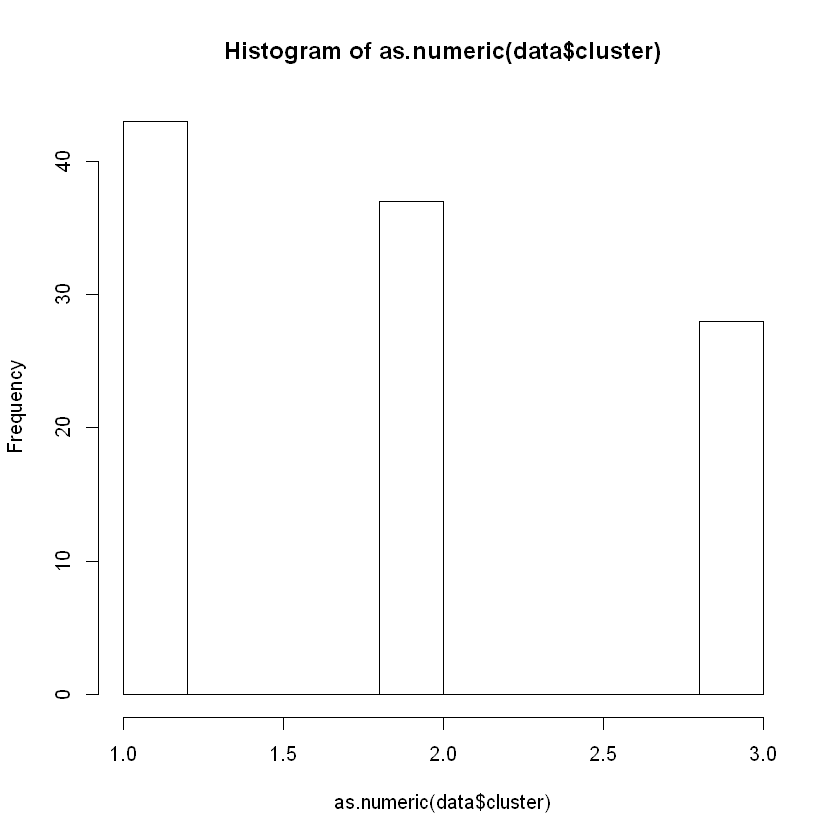

In [67]:
hist(as.numeric(data$cluster))

In [164]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 101
samp <- createDataPartition(data$cluster, p = 0.7, list = F)

In [165]:

for (i in 1:n) {


    # 학습용 데이터 셋
    data.tr <- subset(data[samp,], select = c(cluster, 배우점수, 조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, clusterd))

    # 검증용 데이터셋
    data.test <- subset(data[-samp,], select = c(cluster, 배우점수, 조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, clusterd))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  103
initial  value 90.328626 
iter  10 value 79.670152
iter  20 value 71.802137
iter  30 value 66.873114
iter  40 value 53.785629
iter  50 value 51.256937
iter  60 value 49.747229
iter  70 value 39.699251
iter  80 value 36.148098
iter  90 value 30.965627
iter 100 value 27.767468
final  value 27.767468 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 109.131478 
iter  10 value 78.895364
iter  20 value 71.870184
iter  30 value 58.238260
iter  40 value 43.293767
iter  50 value 31.950429
iter  60 value 31.836827
iter  70 value 30.830605
iter  80 value 30.222455
iter  90 value 29.564647
iter 100 value 29.112017
final  value 29.112017 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 

initial  value 94.656036 
iter  10 value 82.305930
iter  20 value 79.436467
iter  30 value 76.101649
iter  40 value 65.010436
iter  50 value 60.721332
iter  60 value 55.624741
iter  70 value 52.695265
iter  80 value 46.413565
iter  90 value 42.821658
iter 100 value 40.607918
final  value 40.607918 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 87.632605 
iter  10 value 78.401273
iter  20 value 64.947742
iter  30 value 54.232258
iter  40 value 50.860724
iter  50 value 44.566894
iter  60 value 42.783302
iter  70 value 41.504113
iter  80 value 36.405541
iter  90 value 35.031094
iter 100 value 34.505798
final  value 34.505798 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  3

initial  value 91.761247 
iter  10 value 76.623322
iter  20 value 64.174426
iter  30 value 52.776976
iter  40 value 39.421511
iter  50 value 34.987312
iter  60 value 34.317234
iter  70 value 33.820689
iter  80 value 33.560671
iter  90 value 33.486962
iter 100 value 33.297221
final  value 33.297221 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 93.014012 
iter  10 value 81.201840
iter  20 value 71.227560
iter  30 value 68.807660
iter  40 value 65.229169
iter  50 value 56.972053
iter  60 value 52.633051
iter  70 value 51.321672
iter  80 value 50.787144
iter  90 value 50.619116
iter 100 value 50.593640
final  value 50.593640 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  3

initial  value 86.624320 
iter  10 value 78.971767
iter  20 value 69.185201
iter  30 value 57.958079
iter  40 value 53.861267
iter  50 value 53.355581
iter  60 value 53.076553
iter  70 value 52.939568
iter  80 value 52.685658
iter  90 value 41.102669
iter 100 value 36.462025
final  value 36.462025 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 97.860280 
iter  10 value 77.813788
iter  20 value 61.723372
iter  30 value 49.365374
iter  40 value 32.874670
iter  50 value 25.787267
iter  60 value 22.044466
iter  70 value 20.368349
iter  80 value 19.851035
iter  90 value 15.136023
iter 100 value 11.412083
final  value 11.412083 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  3

initial  value 84.882586 
iter  10 value 78.420922
iter  20 value 58.761973
iter  30 value 43.521209
iter  40 value 23.190958
iter  50 value 16.594558
iter  60 value 15.095111
iter  70 value 14.105283
iter  80 value 13.898359
iter  90 value 13.686335
iter 100 value 12.599545
final  value 12.599545 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 96.584347 
iter  10 value 81.261958
iter  20 value 72.510158
iter  30 value 63.328016
iter  40 value 50.946102
iter  50 value 46.334234
iter  60 value 42.629587
iter  70 value 41.844164
iter  80 value 41.681749
iter  90 value 41.645719
iter 100 value 41.630713
final  value 41.630713 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  3

initial  value 97.578144 
iter  10 value 78.865719
iter  20 value 64.100965
iter  30 value 51.672256
iter  40 value 38.791155
iter  50 value 34.739272
iter  60 value 29.948346
iter  70 value 29.305786
iter  80 value 26.747534
iter  90 value 21.055269
iter 100 value 17.443674
final  value 17.443674 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 90.801969 
iter  10 value 78.382744
iter  20 value 74.480404
iter  30 value 73.485822
iter  40 value 72.647543
iter  50 value 68.704667
iter  60 value 67.561243
iter  70 value 67.052043
iter  80 value 63.220702
iter  90 value 53.138454
iter 100 value 51.405324
final  value 51.405324 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  3

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 87.843019 
iter  10 value 79.277719
iter  20 value 63.638007
iter  30 value 49.905527
iter  40 value 46.188298
iter  50 value 43.615041
iter  60 value 39.756511
iter  70 value 36.099339
iter  80 value 27.151799
iter  90 value 25.590611
iter 100 value 25.178423
final  value 25.178423 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 120.667607 
iter  10 value 81.076475
iter  20 value 75.602886
iter  30 value 73.826568
iter  40 value 72.307884
iter  50 value 72.081038
iter  60 value 71.113056
iter  70 value 68.757694
iter  80 value 68.237278
iter  90 valu

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 104.065162 
iter  10 value 81.207026
iter  20 value 76.371225
iter  30 value 70.110672
iter  40 value 70.001673
iter  50 value 69.999675
final  value 69.999671 
converged
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 152.291067 
iter  10 value 82.976986
iter  20 value 78.686218
iter  30 value 78.053808
iter  40 value 78.048179
iter  50 value 70.491523
iter  60 value 55.729814
iter  70 value 33.618533
iter  80 value 31.236957
iter  90 value 30.305446
iter 100 value 30.275933
final  value 30.275933 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 108.085887 
iter  10 value 81.351607
iter  20 value 73.713718
iter  30 value 66.049658
iter  40 value 57.343528
iter  50 value 53.781371
iter  60 value 52.422486
iter  70 value 40.745911
iter  80 value 34.345047
iter  90 value 31.685722
iter 100 value 30.761920
final  value 30.761920 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 88.516515 
iter  10 value 75.734221
iter  20 value 65.442143
iter  30 value 57.573222
iter  40 value 55.832357
iter  50 value 49.890555
iter  60 value 38.765890
iter  70 value 36.734058
iter  80 value 36.680552
iter  90 valu

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 102.909929 
iter  10 value 79.015582
iter  20 value 70.834655
iter  30 value 63.153273
iter  40 value 54.764019
iter  50 value 52.347443
iter  60 value 51.821351
iter  70 value 51.645986
iter  80 value 51.609000
iter  90 value 51.504732
iter 100 value 51.475541
final  value 51.475541 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 99.798644 
iter  10 value 81.717941
iter  20 value 71.631180
iter  30 value 47.535383
iter  40 value 36.580200
iter  50 value 31.171451
iter  60 value 29.999190
iter  70 value 27.059513
iter  80 value 22.997952
iter  90 valu

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 95.661493 
iter  10 value 75.703216
iter  20 value 58.066664
iter  30 value 46.074078
iter  40 value 31.477736
iter  50 value 20.062866
iter  60 value 13.044826
iter  70 value 12.849329
iter  80 value 12.828460
iter  90 value 12.817088
iter 100 value 12.815781
final  value 12.815781 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 94.344096 
iter  10 value 78.484922
iter  20 value 66.934019
iter  30 value 51.434790
iter  40 value 45.210758
iter  50 value 42.420290
iter  60 value 35.138472
iter  70 value 33.305401
iter  80 value 32.836542
iter  90 value

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 126.327454 
iter  10 value 83.344602
iter  20 value 81.579420
iter  30 value 79.807123
iter  40 value 75.966669
iter  50 value 73.103359
iter  60 value 65.933607
iter  70 value 45.987355
iter  80 value 34.822924
iter  90 value 32.557079
iter 100 value 30.935031
final  value 30.935031 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 85.177779 
iter  10 value 77.444770
iter  20 value 65.571626
iter  30 value 43.320253
iter  40 value 32.837396
iter  50 value 29.073016
iter  60 value 28.356328
iter  70 value 27.023855
iter  80 value 23.749761
iter  90 valu

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 101.864480 
iter  10 value 79.164317
iter  20 value 73.581412
iter  30 value 63.734356
iter  40 value 52.666514
iter  50 value 51.449904
iter  60 value 49.563135
iter  70 value 48.543301
iter  80 value 43.104740
iter  90 value 32.806559
iter 100 value 28.711987
final  value 28.711987 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 98.088717 
iter  10 value 77.200869
iter  20 value 65.241821
iter  30 value 58.885900
iter  40 value 56.791058
iter  50 value 56.233317
iter  60 value 54.779310
iter  70 value 54.028311
iter  80 value 53.586506
iter  90 valu

initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 95.571450 
iter  10 value 76.093911
iter  20 value 57.365403
iter  30 value 44.071307
iter  40 value 36.320336
iter  50 value 22.160403
iter  60 value 17.242324
iter  70 value 14.251857
iter  80 value 14.161712
iter  90 value 14.051215
iter 100 value 13.944038
final  value 13.944038 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 84.593146 
iter  10 value 66.671986
iter  20 value 36.684517
iter  30 value 35.708969
iter  40 value 35.703644
iter  50 value 35.652337
final  value 35.652108 
converged
# weights:  103
initial  value 104.295039 
iter  10 value 78.706937
iter  20 value 64.510932
iter  30 value 45.975419
iter  40 value 30.545439
iter  50 value 26.854985
iter  60 value 25.302287
iter  70 value 24.098307
iter  80 value 23.493807
iter  90 valu

In [166]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.8059663,0.7012987,1.0000000,0.8571429,0.8051948
테스트,0.5301821,0.5161290,0.6802938,0.6451613,0.5806452


In [38]:
data

cluster,스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,조연점수,clusterd
1,23.79760,2,10,3,3.000000,4.000000,8.000000,1.714286
1,48.26242,2,10,8,2.000000,8.250000,12.250000,1.714286
1,36.90476,1,10,0,2.333333,4.000000,10.600000,1.000000
1,35.27944,3,10,3,3.571429,6.777778,10.600000,1.952381
1,21.64329,3,10,0,3.500000,7.666667,14.500000,1.896552
1,28.49592,2,20,6,3.500000,6.500000,11.500000,1.714286
1,18.14320,1,10,1,3.571429,6.777778,7.900000,1.000000
1,40.17705,3,10,5,1.500000,11.750000,10.250000,1.952381
1,34.01942,1,10,7,4.000000,4.000000,8.000000,1.000000
1,32.55022,3,10,4,4.000000,11.375000,7.000000,1.952381


In [39]:
# write.csv(data, "./배급사변경testdata.csv", row.names=F)

In [44]:
tt <- subset(mdata, 배급사 == "(주)넥스트엔터테인먼트월드(NEW)" |  배급사 == "(주)롯데엔터테인먼트" |  배급사 == "(주)쇼박스" |  배급사 == "CJ ENM" )

In [45]:
nrow(tt)

[1] 99

In [52]:
ttt <- data[rownames(subset(tt, select = c(cluster, 스크린점유율, 장르_관객점수부여, 감독_배우시너지, 감독점수, 배우점수, clusterd))),]

In [55]:
table(ttt$cluster)


 1  2  3 
37 37 25 

In [60]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 101
samp <- createDataPartition(ttt$cluster, p = 0.7, list = F)
for (i in 1:n) {


    # 학습용 데이터 셋
    data.tr <- subset(ttt[samp,], select = c(cluster, 배우점수, 조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, clusterd))

    # 검증용 데이터셋
    data.test <- subset(ttt[-samp,], select = c(cluster, 배우점수, 조연점수,  스크린점유율, 감독점수, 장르_관객점수부여, clusterd))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  103
initial  value 76.448922 
iter  10 value 67.734826
iter  20 value 56.063417
iter  30 value 40.942494
iter  40 value 36.360648
iter  50 value 33.551246
iter  60 value 31.186119
iter  70 value 25.125549
iter  80 value 18.826270
iter  90 value 18.267325
iter 100 value 17.622871
final  value 17.622871 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 98.682013 
iter  10 value 73.919452
iter  20 value 63.293111
iter  30 value 48.204722
iter  40 value 30.060444
iter  50 value 26.791282
iter  60 value 22.203597
iter  70 value 19.732400
iter  80 value 17.004674
iter  90 value 16.738552
iter 100 value 16.380320
final  value 16.380320 
stopped after 100 iterations
# weights:  24 (14 va

initial  value 109.918502 
iter  10 value 69.424739
iter  20 value 49.288608
iter  30 value 44.569827
iter  40 value 41.891808
iter  50 value 34.410482
iter  60 value 22.460557
iter  70 value 20.295517
iter  80 value 18.550357
iter  90 value 17.756256
iter 100 value 17.341792
final  value 17.341792 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 134.327265 
iter  10 value 75.333650
iter  20 value 68.460537
iter  30 value 65.593635
iter  40 value 64.708382
iter  50 value 64.404602
iter  60 value 64.383415
iter  70 value 64.380581
iter  80 value 64.379455
iter  90 value 64.379167
final  value 64.378924 
converged
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979

initial  value 107.520564 
iter  10 value 74.924818
iter  20 value 61.517635
iter  30 value 37.181357
iter  40 value 34.608894
iter  50 value 29.776285
iter  60 value 20.001988
iter  70 value 16.352888
iter  80 value 15.948700
iter  90 value 12.644725
iter 100 value 10.808351
final  value 10.808351 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 82.870330 
iter  10 value 71.848712
iter  20 value 56.211854
iter  30 value 43.665834
iter  40 value 39.706841
iter  50 value 38.021730
iter  60 value 36.282609
iter  70 value 35.540639
iter  80 value 33.953448
iter  90 value 32.769016
iter 100 value 27.086616
final  value 27.086616 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

initial  value 119.927832 
iter  10 value 75.896816
iter  20 value 71.826424
iter  30 value 71.777110
iter  40 value 67.013610
iter  50 value 63.538769
iter  60 value 52.630451
iter  70 value 38.993988
iter  80 value 36.310392
iter  90 value 32.345177
iter 100 value 29.417187
final  value 29.417187 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 90.693923 
iter  10 value 73.474978
iter  20 value 66.453562
iter  30 value 53.059140
iter  40 value 45.698448
iter  50 value 41.682259
iter  60 value 34.539801
iter  70 value 25.116264
iter  80 value 19.492930
iter  90 value 18.606209
iter 100 value 18.193439
final  value 18.193439 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

initial  value 76.982559 
iter  10 value 70.943890
iter  20 value 65.904035
iter  30 value 63.250851
iter  40 value 61.168470
iter  50 value 60.919008
iter  60 value 60.844818
iter  70 value 59.995702
iter  80 value 54.252495
iter  90 value 49.866358
iter 100 value 48.638955
final  value 48.638955 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 125.223396 
iter  10 value 70.423991
iter  20 value 62.019250
iter  30 value 55.763353
iter  40 value 48.323302
iter  50 value 32.474832
iter  60 value 28.228644
iter  70 value 26.171105
iter  80 value 25.756303
iter  90 value 25.330213
iter 100 value 25.282702
final  value 25.282702 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

initial  value 80.389124 
iter  10 value 71.991337
iter  20 value 68.077461
iter  30 value 63.452855
iter  40 value 56.395916
iter  50 value 47.368865
iter  60 value 34.317535
iter  70 value 26.739491
iter  80 value 23.967728
iter  90 value 23.306046
iter 100 value 23.262338
final  value 23.262338 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 107.718278 
iter  10 value 69.395354
iter  20 value 57.782217
iter  30 value 40.066710
iter  40 value 32.390897
iter  50 value 29.627183
iter  60 value 27.413840
iter  70 value 25.470168
iter  80 value 23.168592
iter  90 value 21.200839
iter 100 value 20.457752
final  value 20.457752 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 91.245303 
iter  10 value 72.690368
iter  20 value 58.913917
iter  30 value 49.765057
iter  40 value 43.426629
iter  50 value 35.091420
iter  60 value 29.590410
iter  70 value 27.952042
iter  80 value 27.304928
iter  90 value 27.058160
iter 100 value 25.912429
final  value 25.912429 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 89.711643 
iter  10 value 70.158719
iter  20 value 46.494721
iter  30 value

initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 97.929514 
iter  10 value 69.233485
iter  20 value 62.024642
iter  30 value 55.648146
iter  40 value 38.859995
iter  50 value 29.128353
iter  60 value 25.499389
iter  70 value 25.291191
iter  80 value 24.952045
iter  90 value 24.438417
iter 100 value 24.059700
final  value 24.059700 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 78.413323 
iter  10 value 73.938828
iter  20 value 65.082489
iter  30 value

initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 90.289995 
iter  10 value 75.255015
iter  20 value 65.566502
iter  30 value 48.353497
iter  40 value 41.059522
iter  50 value 33.128048
iter  60 value 31.545169
iter  70 value 31.154978
iter  80 value 26.487853
iter  90 value 19.297636
iter 100 value 18.015987
final  value 18.015987 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 81.155534 
iter  10 value 74.494368
iter  20 value 69.334249
iter  30 value

initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 99.900490 
iter  10 value 69.474807
iter  20 value 57.736941
iter  30 value 45.146843
iter  40 value 37.927661
iter  50 value 37.141524
iter  60 value 36.995012
iter  70 value 36.572144
iter  80 value 36.516162
iter  90 value 36.435256
iter 100 value 36.082765
final  value 36.082765 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 81.977351 
iter  10 value 68.227817
iter  20 value 63.634263
iter  30 value

initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 83.123984 
iter  10 value 69.034667
iter  20 value 55.227832
iter  30 value 32.633027
iter  40 value 24.089334
iter  50 value 14.791063
iter  60 value 13.877213
iter  70 value 13.873150
iter  80 value 13.873013
iter  90 value 13.873004
final  value 13.872982 
converged
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 81.944229 
iter  10 value 68.903873
iter  20 value 38.118763
iter  30 value 30.232084
iter  40 value 27.337557
iter  50

initial  value 96.916729 
iter  10 value 70.708817
iter  20 value 60.126920
iter  30 value 53.331022
iter  40 value 50.246711
iter  50 value 49.598577
iter  60 value 49.512662
iter  70 value 49.496235
iter  80 value 49.493753
iter  90 value 49.493028
iter 100 value 49.492646
final  value 49.492646 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 113.324281 
iter  10 value 72.917717
iter  20 value 56.960331
iter  30 value 49.638856
iter  40 value 43.032156
iter  50 value 33.999776
iter  60 value 29.598064
iter  70 value 26.932354
iter  80 value 26.138985
iter  90 value 26.025109
iter 100 value 26.015602
final  value 26.015602 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

initial  value 81.963495 
iter  10 value 73.844729
iter  20 value 56.778478
iter  30 value 43.521215
iter  40 value 42.157685
iter  50 value 41.887374
iter  60 value 40.966881
iter  70 value 33.382472
iter  80 value 29.655501
iter  90 value 28.375980
iter 100 value 28.048077
final  value 28.048077 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 81.539298 
iter  10 value 65.226203
iter  20 value 43.774657
iter  30 value 35.977003
iter  40 value 30.184836
iter  50 value 25.479246
iter  60 value 21.379941
iter  70 value 19.898532
iter  80 value 18.313525
iter  90 value 17.296986
iter 100 value 17.026789
final  value 17.026789 
stopped after 100 iterations
# weights:  24 (14 variable)
initial 

initial  value 91.010274 
iter  10 value 74.880938
iter  20 value 71.159443
iter  30 value 58.805679
iter  40 value 36.501006
iter  50 value 30.100907
iter  60 value 28.084072
iter  70 value 27.709776
iter  80 value 23.921924
iter  90 value 22.638660
iter 100 value 22.177196
final  value 22.177196 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 76.939628 
iter  10 value 74.255751
iter  20 value 69.842268
iter  30 value 58.252015
iter  40 value 57.438172
iter  50 value 55.128594
iter  60 value 51.597273
iter  70 value 50.109877
iter  80 value 49.853735
iter  90 value 49.591996
iter 100 value 49.234779
final  value 49.234779 
stopped after 100 iterations
# weights:  24 (14 variable)
initial 

initial  value 80.101853 
iter  10 value 70.151357
iter  20 value 55.204338
iter  30 value 41.895011
iter  40 value 38.783932
iter  50 value 33.206120
iter  60 value 26.379759
iter  70 value 20.398791
iter  80 value 17.697734
iter  90 value 16.776474
iter 100 value 15.955765
final  value 15.955765 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 85.865690 
iter  10 value 69.497910
iter  20 value 50.882906
iter  30 value 40.445622
iter  40 value 36.524395
iter  50 value 34.336436
iter  60 value 30.693778
iter  70 value 28.113648
iter  80 value 27.142781
iter  90 value 25.883068
iter 100 value 24.746282
final  value 24.746282 
stopped after 100 iterations
# weights:  24 (14 variable)
initial 

initial  value 106.345544 
iter  10 value 72.804537
iter  20 value 56.949632
iter  30 value 35.500068
iter  40 value 32.786449
iter  50 value 28.408079
iter  60 value 27.503275
iter  70 value 27.226495
iter  80 value 27.165081
iter  90 value 27.122184
iter 100 value 27.121755
final  value 27.121755 
stopped after 100 iterations
# weights:  24 (14 variable)
initial  value 76.902860 
iter  10 value 59.096979
iter  20 value 38.353360
iter  30 value 34.856549
iter  40 value 34.773670
iter  50 value 33.244549
iter  60 value 31.365819
iter  70 value 31.362886
iter  80 value 31.361074
final  value 31.360967 
converged
# weights:  103
initial  value 80.719619 
iter  10 value 72.307273
iter  20 value 60.389243
iter  30 value 48.240142
iter  40 value 46.447868
iter  50 value 43.855616
iter  60 value 40.757213
iter  70 value 37.161636
iter  80 value 35.553215
iter  90 value 35.143709
iter 100 value 34.870163
final  value 34.870163 
stopped after 100 iterations
# weights:  24 (14 variable)
initial

In [61]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.8244696,0.6714286,1.0000000,0.8857143,0.8000000
테스트,0.5223626,0.5172414,0.6742916,0.5862069,0.6206897
